In [1]:
import tensorflow as tf
from tensorflow.keras import layers

import os
import pandas as pd
import json
import numpy as np

### vauth

In [2]:
from google.colab import auth
auth.authenticate_user()


# preprosessing

## extract features from files and make a dataframe

In [22]:
#help function to import data as dataframes
def import_to_df(folder, start, end): 
  
  #preprosess filenames
  filenamessorted = []
  for filename in os.listdir(folder):
      if ("data" not in filename):
          continue
      file_path = os.path.join(folder, filename)
      with open(file_path) as f:
        try: 
          entry = json.loads(f.readline())
          filenamessorted.append((filename,entry['timestamp']))
        except:
          continue
  filenamessorted.sort(key=lambda a: a[1])
  files = [t[0] for t in filenamessorted]
  filessliced = files[start:end]
 
  print(filessliced)

  data = []
  errors = 0
  for filename in filessliced:
      file_path = os.path.join(folder, filename)
      with open(file_path) as f:
          # Extract the relevant features from each log entry
          for line in f:
              try:
                  entry = json.loads(line)
                  # Extract the relevant features from the entry and add them to the data list
                  features = {'latency': entry['httpRequest']['latency'],
                              'requestSize': entry['httpRequest']['requestSize'],
                              'requestMethod': entry['httpRequest']['requestMethod'],
                              'responseSize': entry['httpRequest']['responseSize'],
                              'requestUrl': entry['httpRequest']['requestUrl'],
                              'status': entry['httpRequest']['status'],
                              'source_app': entry['labels']['source_app'],
                              'timestamp': entry['timestamp']}
                  data.append(features)
              except json.JSONDecodeError:
                  # Handle JSONDecodeError and continue to the next line
                  errors += 1
                  print(f"Error decoding JSON in file {file_path}: {line}")
                  continue
              except KeyError:
                  # Error and continue to the next line
                  errors += 1
                  print(f"KEY error in file {file_path}: {line}")
                  continue


  # Convert the list of dictionaries into a DataFrame
  print("Number of errors: " + str(errors))
  df = pd.DataFrame(data)

  df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
  df.set_index('timestamp', inplace=True)
  df = df.sort_index()

  dforiginal = df.copy()
  return df, dforiginal


## import train

In [25]:
''' ---- real call:'''
#train_df,train_dforiginal = import_to_df("/content/normal",17,40);

''' ---- testing calls:'''
train_df,train_dforiginal = import_to_df("/content/normal",17,25);


['data000000000018', 'data000000000019', 'data000000000021', 'data000000000020', 'data000000000022', 'data000000000024', 'data000000000023', 'data000000000025']
Number of errors: 0


## import test

In [24]:
''' ---- real call: '''
#test_df,test_dforiginal  = import_to_df("/content/anomaly",39, 50);

'''---- testing calls:
'''
test_df, test_dforiginal = import_to_df("/content/anomaly",39,45);


['data-000000000046', 'data-000000000034', 'data-000000000030', 'data-000000000048', 'data-000000000043', 'data-000000000051']
Number of errors: 0


## Latency

### plot

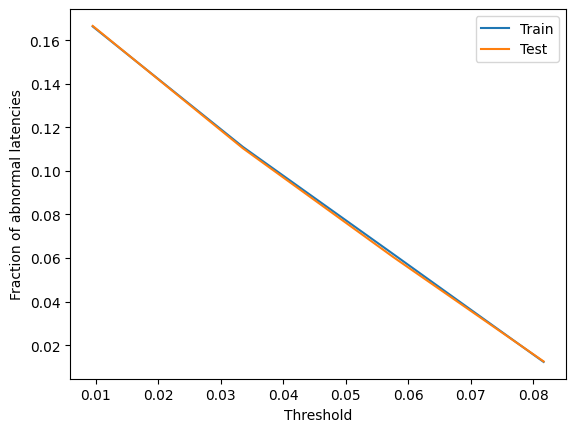

   Threshold  Train Fraction  Test Fraction
0   0.009522        0.166284       0.166527
1   0.033578        0.110956       0.110322
2   0.057634        0.061775       0.060408
3   0.081690        0.012293       0.012522


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


latency_mean = train_df['latency'].mean()
latency_std = train_df['latency'].std()
thresholds = []

for i in range(4):

# Define threshold for abnormal latency as three standard deviations away from the mean of TrainDF
  thresholds.append(latency_mean + i*latency_std)

# Define empty lists to store results
train_labels_list = []
train_fractions_list = []
test_labels_list = []
test_fractions_list = []

# Loop over threshold values
for threshold in thresholds:

    train_df['latency_label'] = np.where(train_df['latency'] > threshold, 1, 0)
    test_df['latency_label'] = np.where(test_df['latency'] > threshold, 1, 0)

    # Compute fraction of abnormal latencies
    train_fraction = train_df['latency_label'].value_counts()[1]/train_df.shape[0]
    test_fraction = test_df['latency_label'].value_counts()[1]/test_df.shape[0]
    #test_fraction = test_df['latency_label'].mean()

    # Append results to lists
    train_labels_list.append(train_df['latency_label'])
    train_fractions_list.append(train_fraction)
    test_labels_list.append(test_df['latency_label'])
    test_fractions_list.append(test_fraction)


# Plot results
plt.plot(thresholds, train_fractions_list, label='Train')
plt.plot(thresholds, test_fractions_list, label='Test')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Fraction of abnormal latencies')
plt.show()

# Create table of results
results = pd.DataFrame({'Threshold': thresholds, 'Train Fraction': train_fractions_list, 'Test Fraction': test_fractions_list})
print(results)


In [54]:
train_df['latency_label'].value_counts(),test_df['latency_label'].value_counts()

(0    336898
 1      4193
 Name: latency_label, dtype: int64,
 0    240609
 1      3051
 Name: latency_label, dtype: int64)

### determine

In [55]:
treshold = (latency_mean + 2*latency_std)

train_df['latency_label'] = np.where(train_df['latency'] > threshold, 1, 0)
test_df['latency_label'] = np.where(test_df['latency'] > threshold, 1, 0)


## backup and debugging

In [12]:
print(train_dforiginal.shape, len(train_df))
print(test_dforiginal.shape, len(test_df))


(10000, 7) 10000
(10000, 7) 10000


In [ ]:
earliest_train = train_df.index.min()
latest_train = train_df.index.max()
earliest_test = test_df.index.min()
latest_test = test_df.index.max()

print("Earliest train timestamp:", earliest_train)
print("Latest train timestamp:", latest_train)
print("Earliest test timestamp:", earliest_test)
print("Latest test timestamp:", latest_test)


Earliest train timestamp: 2023-04-18 00:28:36.741168+00:00
Latest train timestamp: 2023-04-18 00:57:39.686390+00:00
Earliest test timestamp: 2023-04-21 00:07:40.949091+00:00
Latest test timestamp: 2023-04-21 01:07:49.241144+00:00


In [ ]:
# in case of error
train_df = train_dforiginal
test_df = test_dforiginal

print(train_df.head)
print(test_df.head)

In [ ]:
# assuming the dataframe is named 'df'
num_combinations = train_df.drop_duplicates().shape[0]
print(num_combinations)

311


In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
!nvidia-smi

Tue May  9 11:16:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    52W / 400W |    691MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## create keyes and dummies

In [9]:
train_df.to_csv('train.csv', index=True)
test_df.to_csv('test.csv', index=True)

In [10]:
# concatenate the dataframes
df_concat = pd.concat([test_df, train_df], axis=0)


# create keys for both dataframes
df_concat['key'] = df_concat.groupby(['latency_label', 'requestSize', 'requestMethod', 'responseSize',
       'requestUrl', 'status', 'source_app'], dropna=False).ngroup()

# get dummies for the 'key' column
df_concat=df_concat[['key']]
df_concat = pd.get_dummies(df_concat, columns=['key'])


# split back into original dataframes
test_df = df_concat.iloc[:len(test_df), :]
train_df = df_concat.iloc[len(test_df):, :]

In [ ]:
print(train_df.shape)
print(test_df.shape)
print(test_df.head())

# AUTOENCODER

## Datasets

### Function

## gpu test

In [ ]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
tf.config.experimental.list_physical_devices('GPU')

Found GPU at: /device:GPU:0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## timeseries

In [12]:
num_steps = 20
features = train_df.shape[1]
x_train_shaped = np.reshape((train_df.iloc[:341080]).to_numpy(), newshape=(-1, num_steps, features))




#train_gen = TimeseriesGenerator(train_data, train_data, length=seq_length, batch_size=batch_size)

In [14]:
features = train_df.shape[1]
x_test_shaped = np.reshape((test_df).to_numpy(), newshape=(-1, num_steps, features))




In [16]:
x_train_shaped.shape, x_test_shaped.shape

((17054, 20, 417), (12183, 20, 417))

## define model

In [17]:
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Dense


# Define the model 
model = Sequential()

# Encoder
model.add(LSTM(128, activation='tanh', input_shape=(x_train_shaped.shape[1],x_train_shaped.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='tanh', return_sequences=False))
model.add(RepeatVector(x_train_shaped.shape[1]))

# Decoder
model.add(LSTM(64, activation='tanh', return_sequences=True))
model.add(LSTM(128, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(x_train_shaped.shape[2])))

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 128)           279552    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 repeat_vector (RepeatVector  (None, 20, 64)           0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 20, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 20, 128)           98816     
                                                                 
 time_distributed (TimeDistr  (None, 20, 417)          53793     
 ibuted)                                                

In [18]:
model.layers[0].input_shape


(None, 20, 417)

### fit

Epoch 1/200
427/427 [==============================] - 18s 14ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 2/200
427/427 [==============================] - 4s 10ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 3/200
427/427 [==============================] - 5s 11ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 4/200
427/427 [==============================] - 4s 10ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 5/200
427/427 [==============================] - 4s 10ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 6/200
427/427 [==============================] - 4s 10ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 7/200
427/427 [==============================] - 4s 10ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 8/200
427/427 [==============================] - 4s 10ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 9/200
427/427 [==============================] - 4s 10ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 10/200
427/427 [==============================] - 4s 10ms/step - loss: 0.00

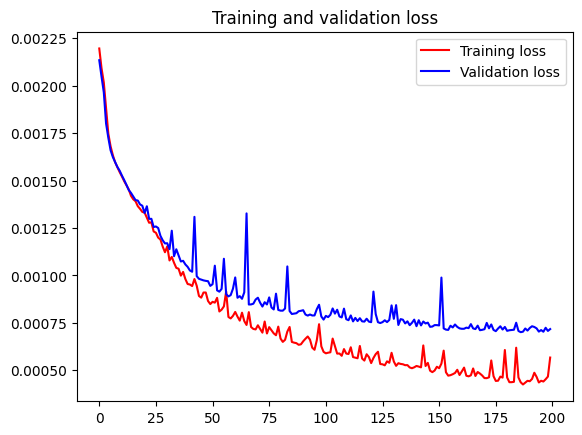

In [19]:
import matplotlib.pyplot as plt

epochs = 200

history = model.fit(x_train_shaped,x_train_shaped, epochs=epochs, validation_split=0.2)

# Plot training and validation loss over epochs
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### predict train

In [92]:
with tf.device('/cpu:0'):
  X_pred = model.predict(x_train_shaped)

32/32 [==============================] - 2s 20ms/step


In [ ]:
# Plot predicted vs. actual
plt.plot(x_train_shaped.flatten(), label='Actual')
plt.plot(X_pred.flatten(), label='Predicted')
plt.legend()
plt.show()

### Predict test

In [97]:
#with tf.device('/device:GPU:0'):
X_pred_test = model.predict(x_test_shaped)

32/32 [==============================] - 0s 4ms/step


In [128]:
# save the model
model.save('my_model.h5')

# ML

# Classify

In [99]:
from sklearn.metrics import mean_squared_error

# Iterate over each sequence in X_train

def calc_mse(X,X_predict):
  mse_list = []
  for i in range(X.shape[0]):
      # Get the current sequence
      sequence = X[i]

      # Calculate the mean squared error for the sequence
      mse = mean_squared_error(sequence, X_predict[i])
      mse_list.append(mse)
  return mse_list

In [101]:
mse_train = calc_mse(x_train_shaped, X_pred)
mse_train[:10]

[0.0009648893,
 0.0016433381,
 0.00209405,
 0.00196355,
 0.0022053425,
 0.0022250116,
 0.0020170284,
 0.0018587692,
 0.0019730492,
 0.0015563897]

In [102]:
mse_test = calc_mse(x_test_shaped, X_pred_test)
mse_test[:10]

[0.0025950328,
 0.002417322,
 0.0027495099,
 0.0024953983,
 0.0024975683,
 0.0023612643,
 0.0024932441,
 0.002334594,
 0.0022397381,
 0.0019854724]

### TRESHOLD

In [123]:
mean_error = np.mean(mse_train)
std_error = np.std(mse_train)

# Set threshold as a certain number of standard deviations from the mean
num_std = 0.5  # Set number of standard deviations away from mean
threshold = mean_error + num_std * std_error

print(f"Threshold: {threshold}")

Threshold: 0.00202481729502324


### create classification vector

In [118]:
def classify(mse_list):
  classified = []
  for i in range(x_train_shaped.shape[0]):
    classified.append(0 if mse_list[i] < threshold else 1)
  return classified

In [124]:
train_classified = classify(mse_train)
test_classified = classify(mse_test)

In [ ]:
train_classified[:10],test_classified[:10]

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# result analysis

# metrics

In [125]:
TP = test_classified.count(1)
FP = train_classified.count(1)
TN = train_classified.count(0)
FN = test_classified.count(0)

In [126]:
accuracy = (TP + TN) / (TP + FP + TN + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
specificity = TN / (TN + FP)
fpr = FP / (TN + FP)


In [127]:
confusion_matrix = pd.DataFrame(
    {
        '': ['Actual Positive', 'Actual Negative'],
        'Predicted Positive': [TP, FP],
        'Predicted Negative': [FN, TN]
    }
)

# Convert the dataframe to a LaTeX table
confusion_matrix_latex = confusion_matrix.style.to_latex()

# Print the table and the metrics
print(confusion_matrix_latex)
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1_score:.2f}')

\begin{tabular}{llrr}
 &  & Predicted Positive & Predicted Negative \\
0 & Actual Positive & 853 & 147 \\
1 & Actual Negative & 345 & 655 \\
\end{tabular}

Accuracy: 0.75
Precision: 0.71
Recall: 0.85
F1-score: 0.78


# model information to latex

In [ ]:
# Extract important information from train_df and test_df
n_train_samples, n_train_features = train_df.shape
n_test_samples, n_test_features = test_df.shape


# Create a LaTeX table with the extracted information
latex = """
\\begin{table}[ht]
\\centering
\\begin{tabular}{|l|c|c|}
\\hline
\\textbf{Dataset} & \\textbf{Number of Samples} & \\textbf{Number of Features} \\\\
\\hline
Train & %d & %d \\\\
Test & %d & %d \\\\
\\hline
\\end{tabular}
\\caption{Important Information from train\_df and test\_df Datasets}
\\label{tab:dataset-info}
\\end{table}

\\begin{table}[ht]
\\centering
\\begin{tabular}{|l|c|}
\\hline
\\textbf{Parameter} & \\textbf{Value} \\\\
\\hline
Number of Timesteps & %d \\\\
Number of Features & %d \\\\
Latent Dimension & %d \\\\
Batch Size & %d \\\\
\\hline
\\end{tabular}
\\caption{Parameters Used in the LSTM Autoencoder Model}
\\label{tab:model-parameters}
\\end{table}
""" % (n_train_samples, n_train_features, n_test_samples, n_test_features, timesteps, n_features, latent_dim, batch_size)

# Write LaTeX table to file
with open('info.tex', 'w') as f:
    f.write(latex)

In [ ]:
from tabulate import tabulate

# model summary
model_summary = []
model.summary(print_fn=lambda x: model_summary.append(x))
model_summary = '\n'.join(model_summary)

# predicted and actual values
predicted = np.round(yhat, 3)
actual = np.round(X, 3)

# create table
table = [
    ['Model Summary', model_summary],
    ['Predicted Values', predicted],
    ['Actual Values', actual]
]

# convert table to LaTeX format
latex_table = tabulate(table, headers=['Variable', 'Value'], tablefmt='latex')

# print LaTeX table
print(latex_table)


\begin{tabular}{ll}
\hline
 Variable         & Value   \\
\hline
 Model Summary    & Model: "sequential"
\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_
 Layer (type)                Output Shape              Param \#   
 lstm (LSTM)                 (None, 10, 128)           154624    
                                                                 
 lstm\_1 (LSTM)               (None, 64)                49408     
                                                                 
 repeat\_vector (RepeatVector  (None, 10, 64)           0         
 )                                                               
                                                                 
 lstm\_2 (LSTM)               (None, 10, 64)            33024     
                                                                 
 lstm\_3 (LSTM)               (None, 10, 128)           98816     
                                 

In [ ]:
# Reshape X and yhat to 2D arrays
X_2d = X.reshape(X.shape[0]*timesteps, n_features)
yhat_2d = yhat.reshape(X.shape[0]*timesteps, n_features)

In [ ]:
# Calculate mean squared error
mse = mean_squared_error(X_2d, yhat_2d)
print("MSE: ", mse)

MSE:  0.0033856726


In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(X_2d, yhat_2d)
print("R2 score: ", r2)

R2 score:  0.06690389884976325


In [ ]:
data_train = []
errors_train = 0

for file in uploaded_test :
    for line in file:
      try:
          entry = json.loads(line)
          features = {'latency': entry['httpRequest']['latency'],
                      'requestSize': entry['httpRequest']['requestSize'],
                      'requestMethod': entry['httpRequest']['requestMethod'],
                      'responseSize': entry['httpRequest']['responseSize'],
                      'requestUrl': entry['httpRequest']['requestUrl'],
                      'status': entry['httpRequest']['status'],
                      'source_app': entry['labels']['source_app'],
                      'timestamp': entry['timestamp']}          
          # Extract the relevant features from the entry and add them to the data list
          data_train.append(features)
      except json.JSONDecodeError:
          # Handle JSONDecodeError and continue to the next line
          errors_train += 1
          # print(f"Error decoding JSON in file {file_path}: {line}")
          continue

# Convert the list of dictionaries into a DataFrame
print("Number of errors: " + str(errors_train))
df_train = pd.DataFrame(data_train)
df_train.head()

In [ ]:
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
# configure tensorflow to use GPU

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.gpu_options.per_process_gpu_memory_fraction = 0.9  # limit the GPU memory used to 90%
sess = tf.compat.v1.Session(config=config)
set_session(sess)

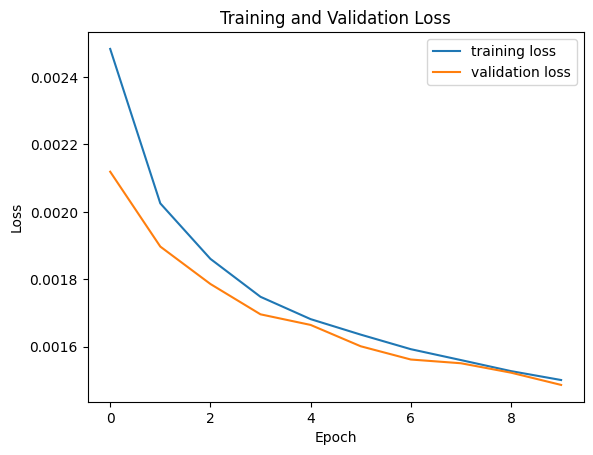

In [ ]:
import matplotlib.pyplot as plt
# plot training and validation loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Create Keys

In [ ]:
#create keys for unique rows

df['key'] = df.groupby(['latency', 'requestSize', 'requestMethod', 'responseSize',
       'requestUrl', 'status', 'source_app']).ngroup()

In [ ]:
#latex

latex_table = df.head().style.to_latex()

# print latex table
print(latex_table)

\begin{tabular}{lrllllllr}
 & latency & requestSize & requestMethod & responseSize & requestUrl & status & source_app & key \\
timestamp &  &  &  &  &  &  &  &  \\
2023-04-15 08:26:58.215025 UTC & 1 & 730 & POST & 1757 & http://productcatalogservice:3550/hipstershop.ProductCatalogService/GetProduct & 200 & frontend & 231 \\
2023-04-15 08:26:58.216662 UTC & 1 & 730 & POST & 1695 & http://productcatalogservice:3550/hipstershop.ProductCatalogService/GetProduct & 200 & frontend & 217 \\
2023-04-15 08:26:58.354216 UTC & 1 & 730 & POST & 1747 & http://productcatalogservice:3550/hipstershop.ProductCatalogService/GetProduct & 200 & frontend & 229 \\
2023-04-15 08:26:58.356309 UTC & 1 & 730 & POST & 1695 & http://productcatalogservice:3550/hipstershop.ProductCatalogService/GetProduct & 200 & frontend & 217 \\
2023-04-15 08:26:58.361683 UTC & 1 & 730 & POST & 1742 & http://productcatalogservice:3550/hipstershop.ProductCatalogService/GetProduct & 200 & frontend & 227 \\
\end{tabular}



In [ ]:
df=df[['key']]

df = pd.get_dummies(df, columns=['key'])

In [ ]:
df.head()

,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,...,key_377,key_378,key_379,key_380,key_381,key_382,key_383,key_384,key_385,key_386
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-04-15 08:26:58.215025 UTC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-04-15 08:26:58.216662 UTC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-04-15 08:26:58.354216 UTC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-04-15 08:26:58.356309 UTC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-04-15 08:26:58.361683 UTC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.preprocessing import StandardScaler


train_size = int(len(df) * 0.95)
train = df[:train_size][df.columns]
test = df[train_size:][df.columns]

In [ ]:
np.argpartition(X[0][0],-1)[-1]

110

In [ ]:
np.argpartition(yhat[0][0],-5)[-5:]

array([ 58,  68, 113,  32,  76])

In [ ]:
#reconstruction cost for the test set


mse = np.mean(np.mean(np.power(X - yhat, 2), axis=1),axis=1)
mse

array([0.00485279, 0.00451607, 0.00409346, ..., 0.00446442, 0.00524236,
       0.00528777], dtype=float32)

# legacy

## timeseries testing

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import LSTM
import tensorflow as tf

# Define the model 
with tf.device('/device:GPU:0'):
  model = tf.keras.Sequential()
  model.add(LSTM(128, activation='tanh', input_shape=(timesteps,n_features), return_sequences=True))
  model.add(LSTM(64, activation='tanh', return_sequences=False))
  model.add(RepeatVector(timesteps))
  model.add(LSTM(64, activation='tanh', return_sequences=True))
  model.add(LSTM(128, activation='tanh', return_sequences=True))
  model.add(TimeDistributed(Dense(n_features)))
  model.compile(optimizer='adam', loss='mse')
  model.summary()
# Write LaTeX table to file
with open('modelsummary.tex', 'w') as f:
    f.write(str(model.summary()))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 128)           271872    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 repeat_vector (RepeatVector  (None, 20, 64)           0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 20, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 20, 128)           98816     
                                                                 
 time_distributed (TimeDistr  (None, 20, 402)          51858     
 ibuted)                                                

In [ ]:
# fit model
model.fit(X, X, epochs=5, batch_size=5, verbose=2)
# demonstrate reconstruction
yhat = model.predict(X, verbose=0)
print('---Predicted---')
print(np.round(yhat,3))
print('---Actual---')
print(np.round(X, 3))

Epoch 1/5
998/998 - 41s - loss: 0.0049 - 41s/epoch - 41ms/step
Epoch 2/5
998/998 - 32s - loss: 0.0043 - 32s/epoch - 32ms/step
Epoch 3/5
998/998 - 32s - loss: 0.0039 - 32s/epoch - 32ms/step
Epoch 4/5
998/998 - 32s - loss: 0.0037 - 32s/epoch - 32ms/step
Epoch 5/5
998/998 - 33s - loss: 0.0035 - 33s/epoch - 33ms/step
---Predicted---
[[[-0.     0.005  0.008 ...  0.001  0.003  0.001]
  [-0.     0.007  0.014 ...  0.001  0.004  0.002]
  [ 0.     0.006  0.015 ...  0.     0.003  0.002]
  ...
  [ 0.007  0.006  0.006 ...  0.003 -0.001 -0.002]
  [ 0.006  0.011  0.008 ...  0.003  0.001 -0.003]
  [ 0.005  0.017  0.012 ...  0.004  0.004 -0.004]]

 [[ 0.     0.006  0.006 ...  0.001  0.003  0.   ]
  [ 0.     0.01   0.012 ...  0.001  0.004  0.002]
  [ 0.     0.01   0.015 ... -0.001  0.004  0.003]
  ...
  [ 0.005  0.01   0.01  ...  0.002  0.    -0.002]
  [ 0.006  0.013  0.011 ...  0.002  0.002 -0.002]
  [ 0.006  0.015  0.012 ...  0.002  0.004 -0.002]]

 [[ 0.001  0.008  0.008 ...  0.001  0.003  0.   ]
  [

In [ ]:
# bug fixing test piece

import os
import json
import pandas as pd

data = []


# Load the JSON file
with open("train/data-000000000021") as f:
# Extract the relevant features from each log entry
    for line in f:
        entry = json.loads(line)
        # Extract the relevant features from the entry and add them to the data list
        features = {'latency': entry['httpRequest']['latency'],
                    'requestSize': entry['httpRequest']['requestSize'],
                    'requestMethod': entry['httpRequest']['requestMethod'],
                    'responseSize': entry['httpRequest']['responseSize'],
                    'requestUrl': entry['httpRequest']['requestUrl'],
                    'status': entry['httpRequest']['status'],
                    'source_app': entry['labels']['source_app'],
                    'timestamp': entry['timestamp']}
        data.append(features)

# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(data)
df.head

In [ ]:
folder_path = './train'  # change this to your folder path
data = []
errors = 0

# Loop through all the files in the folder
for filename in os.listdir(folder_path):
    if ("data" not in filename):
        continue
    file_path = os.path.join(folder_path, filename)
    # Load the JSON file
    with open(file_path) as f:
        # Extract the relevant features from each log entry
        for line in f:
            try:
                entry = json.loads(line)
                # Extract the relevant features from the entry and add them to the data list
                features = {'latency': entry['httpRequest']['latency'],
                            'requestSize': entry['httpRequest']['requestSize'],
                            'requestMethod': entry['httpRequest']['requestMethod'],
                            'responseSize': entry['httpRequest']['responseSize'],
                            'requestUrl': entry['httpRequest']['requestUrl'],
                            'status': entry['httpRequest']['status'],
                            'source_app': entry['labels']['source_app'],
                            'timestamp': entry['timestamp']}
                data.append(features)
            except json.JSONDecodeError:
                # Handle JSONDecodeError and continue to the next line
                errors += 1
                # print(f"Error decoding JSON in file {file_path}: {line}")
                continue

# Convert the list of dictionaries into a DataFrame
print("Number of errors: " + str(errors))
df = pd.DataFrame(data)
df.head()

Number of errors: 18


,latency,requestSize,requestMethod,responseSize,requestUrl,status,source_app,timestamp
0,0.001479,712,POST,1778,http://currencyservice:7000/hipstershop.Curren...,200,frontend,2023-04-15 09:29:32.235081 UTC
1,0.002243,712,POST,1778,http://currencyservice:7000/hipstershop.Curren...,200,frontend,2023-04-15 09:29:27.826092 UTC
2,0.001678,717,POST,1626,http://currencyservice:7000/hipstershop.Curren...,200,frontend,2023-04-15 09:29:29.543643 UTC
3,0.001477,717,POST,1626,http://currencyservice:7000/hipstershop.Curren...,200,frontend,2023-04-15 09:29:32.243186 UTC
4,0.001591,712,POST,1778,http://currencyservice:7000/hipstershop.Curren...,200,frontend,2023-04-15 09:29:31.537701 UTC


In [ ]:
#OLD


import json
import pandas as pd


# Load data from JSON file and Convert data to pandas DataFrame
df = pd.read_json('data.json', convert_dates=['timestamp'])


In [ ]:
import keras

model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64,
    input_shape=(X.shape[1], X.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(
  keras.layers.TimeDistributed(
    keras.layers.Dense(units=X_train.shape[2])
  )
)

model.compile(loss='mae', optimizer='adam')

IndexError: tuple index out of range

In [ ]:
#from sklearn.preprocessing import MinMaxScaler

# Convert categorical features to one-hot encoded format
#df = pd.get_dummies(df, columns=['requestUrl', 'status', 'source_app','requestMethod'])

# Normalize the numerical features
#scaler = MinMaxScaler()
#df[["latency", "requestSize", "responseSize"]] = scaler.fit_transform(df[["latency", "requestSize", "responseSize"]])
#df.columns.values.astype(list)

array(['latency', 'requestSize', 'requestMethod', 'responseSize',
       'requestUrl', 'status', 'source_app'], dtype=object)

In [ ]:

test_array = np.array(test)
test_array = np.reshape(test_array, (test_array.shape[0], 1, test_array.shape[1]))

# Generate predictions on test data
y_pred = model.predict(test_array)

# Denormalize the predicted values
y_pred_denorm = scaler.inverse_transform(y_pred)

# Calculate the mean squared error
mse = np.mean(np.square(test - y_pred_denorm))

print('Test MSE:', mse)


8/8 [==============================] - 1s 3ms/step
Test MSE: latency                                                                                               0.011552
requestSize                                                                                           0.003098
responseSize                                                                                          0.053303
requestUrl_http://adservice:9555/hipstershop.AdService/GetAds                                         0.063806
requestUrl_http://cartservice:7070/hipstershop.CartService/AddItem                                    0.007903
requestUrl_http://cartservice:7070/hipstershop.CartService/EmptyCart                                  0.000008
requestUrl_http://cartservice:7070/hipstershop.CartService/GetCart                                    0.080683
requestUrl_http://checkoutservice:5050/hipstershop.CheckoutService/PlaceOrder                         0.000004
requestUrl_http://currencyservice:7000/hipstershop.

/opt/software/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
